# Description

It runs DBSCAN on the z_score_std version of the data.

The notebook explores different values for min_samples and eps (the main parameters of DBSCAN).

# Environment variables

In [1]:
from IPython.display import display

import conf

N_JOBS = conf.GENERAL['N_JOBS']
display(N_JOBS)

3

In [2]:
%env MKL_NUM_THREADS=$N_JOBS
%env OPEN_BLAS_NUM_THREADS=$N_JOBS
%env NUMEXPR_NUM_THREADS=$N_JOBS
%env OMP_NUM_THREADS=$N_JOBS

env: MKL_NUM_THREADS=3
env: OPEN_BLAS_NUM_THREADS=3
env: NUMEXPR_NUM_THREADS=3
env: OMP_NUM_THREADS=3


# Modules loading

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from pathlib import Path

import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import pairwise_distances
from sklearn.cluster import DBSCAN
import umap
import matplotlib.pyplot as plt
import seaborn as sns

from utils import generate_result_set_name
from clustering.ensemble import generate_ensemble

# Global settings

In [5]:
CLUSTERING_ATTRIBUTES_TO_SAVE = ['n_clusters']

# Data version: z_score_std

## Settings

In [6]:
INPUT_SUBSET = 'z_score_std'

In [7]:
INPUT_STEM = 'projection-smultixcan-efo_partial-mashr-zscores'

In [8]:
input_filepath = Path(
    conf.RESULTS["DATA_TRANSFORMATIONS_DIR"],
    INPUT_SUBSET,
    f'{INPUT_SUBSET}-{INPUT_STEM}.pkl',
).resolve()
display(input_filepath)

assert input_filepath.exists(), 'Input file does not exist'

input_filepath_stem = input_filepath.stem
display(input_filepath_stem)

PosixPath('/home/miltondp/projects/labs/greenelab/phenoplier/base/results/data_transformations/z_score_std/z_score_std-projection-smultixcan-efo_partial-mashr-zscores.pkl')

'z_score_std-projection-smultixcan-efo_partial-mashr-zscores'

In [9]:
# output dir for this notebook
RESULTS_DIR = Path(
    conf.RESULTS["CLUSTERING_RUNS_DIR"],
    f'{INPUT_SUBSET}-{INPUT_STEM}',
).resolve()
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

display(RESULTS_DIR)

PosixPath('/home/miltondp/projects/labs/greenelab/phenoplier/base/results/clustering/runs/z_score_std-projection-smultixcan-efo_partial-mashr-zscores')

## Load input file

In [10]:
data = pd.read_pickle(input_filepath)

In [11]:
data.shape

(3749, 987)

In [12]:
data.head()

,LV1,LV2,LV3,LV4,LV5,LV6,LV7,LV8,LV9,LV10,...,LV978,LV979,LV980,LV981,LV982,LV983,LV984,LV985,LV986,LV987
100001_raw-Food_weight,-0.553743,1.851060,-0.095721,0.931603,-0.515196,1.371264,-0.413165,0.729668,0.546338,0.901153,...,1.148776,1.649018,-1.375952,2.203063,0.810199,-0.987048,0.277710,-0.607613,0.572376,-0.660846
100002_raw-Energy,-1.313905,-0.421015,-0.310524,-0.201978,0.233028,0.693838,0.084129,0.572439,0.217866,1.296973,...,0.165430,0.799276,-0.361989,-0.008253,2.063780,-0.930765,-0.147007,1.601938,-0.273553,-0.560822
100003_raw-Protein,-0.645622,-0.997845,0.249039,0.256499,0.422357,0.829189,-0.169004,0.511550,0.002389,-0.057200,...,1.016791,1.019488,-2.148844,-0.065130,0.041052,-0.836118,-0.320571,1.325519,-0.341494,-0.495786
100004_raw-Fat,-0.913924,-1.837183,0.012095,-1.301315,0.205794,1.129114,0.019985,0.376660,-0.810272,0.843611,...,0.544266,0.576714,0.281731,-0.218963,1.258957,-1.131924,0.378545,0.842047,-0.622194,-0.160058
100005_raw-Carbohydrate,-0.523004,0.131379,-0.097802,-0.030526,-0.021500,-0.219116,0.668229,0.365700,1.102347,0.845625,...,-0.344740,0.079274,0.253427,0.236474,1.033895,-0.229105,0.364793,1.776714,0.190531,-1.459641


In [13]:
assert not data.isna().any().any()

## Tests different k values (k-NN)

In [14]:
k_values = np.arange(2, 120+1, 1)
k_values_to_explore = (2, 5, 10, 15, 20, 30, 40, 50, 75, 100, 125)

In [15]:
results = {}

for k in k_values_to_explore:
    nbrs = NearestNeighbors(n_neighbors=k, n_jobs=N_JOBS).fit(data)
    distances, indices = nbrs.kneighbors(data)
    results[k] = (distances, indices)

In [16]:
min_max_range = (40, 100)

eps_range_per_k = {k: min_max_range for k in k_values}
eps_range_per_k_to_explore = {k: min_max_range for k in k_values_to_explore}

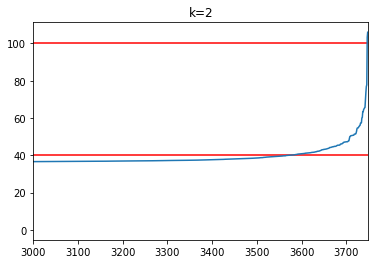

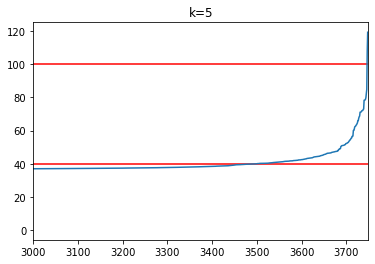

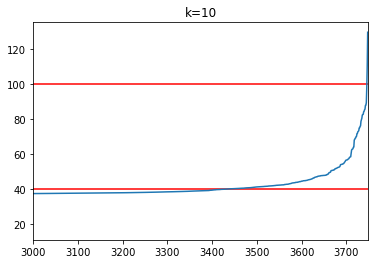

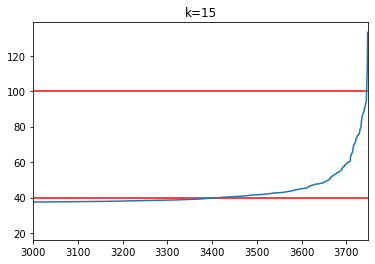

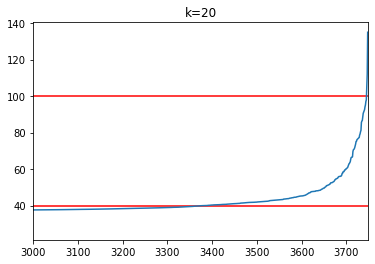

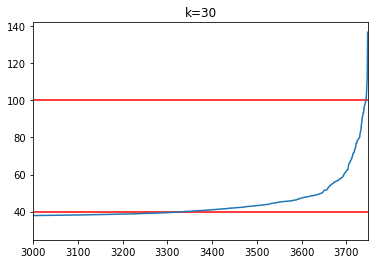

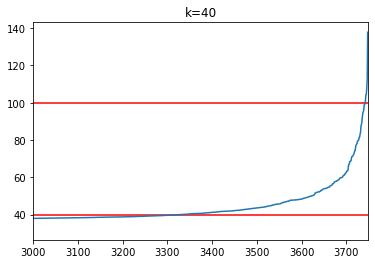

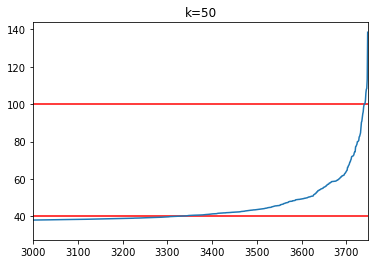

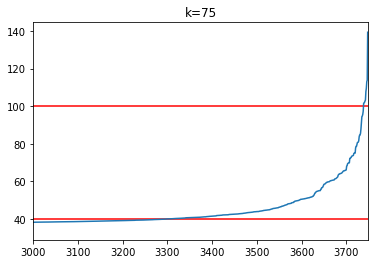

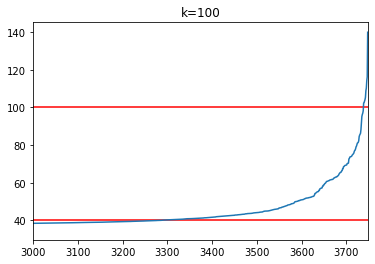

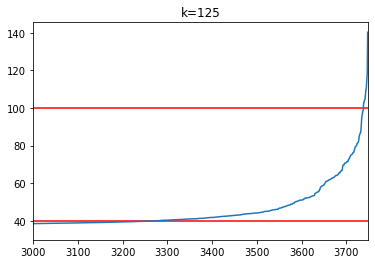

In [17]:
for k, (distances, indices) in results.items():
    d = distances[:,1:].mean(axis=1)
    d = np.sort(d)
    
    fig, ax = plt.subplots()
    plt.plot(d)
    
    r = eps_range_per_k_to_explore[k]
    plt.hlines(r[0], 0, data.shape[0], color='red')
    plt.hlines(r[1], 0, data.shape[0], color='red')
    
    plt.xlim((3000, data.shape[0]))
    plt.title(f'k={k}')
    display(fig)
    
    plt.close(fig)

## Clustering

### Generate clusterers

In [18]:
CLUSTERING_OPTIONS = {}

# K_RANGE is the min_samples parameter in DBSCAN (sklearn)
CLUSTERING_OPTIONS['K_RANGE'] = k_values
CLUSTERING_OPTIONS['EPS_RANGE_PER_K'] = eps_range_per_k
CLUSTERING_OPTIONS['EPS_STEP'] = 33
CLUSTERING_OPTIONS['METRIC'] = 'euclidean'

display(CLUSTERING_OPTIONS)

{'K_RANGE': array([  2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,
         15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
         28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,
         41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,
         54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,
         67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,
         80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,
         93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
        106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
        119, 120]),
 'EPS_RANGE_PER_K': {2: (40, 100),
  3: (40, 100),
  4: (40, 100),
  5: (40, 100),
  6: (40, 100),
  7: (40, 100),
  8: (40, 100),
  9: (40, 100),
  10: (40, 100),
  11: (40, 100),
  12: (40, 100),
  13: (40, 100),
  14: (40, 100),
  15: (40, 100),
  16: (40, 100),
  17: (40, 100),
  18: (40, 100),
  19: (40, 1

In [19]:
CLUSTERERS = {}

idx = 0

for k in CLUSTERING_OPTIONS['K_RANGE']:
    eps_range = CLUSTERING_OPTIONS['EPS_RANGE_PER_K'][k]
    eps_values = np.linspace(
        eps_range[0],
        eps_range[1],
        CLUSTERING_OPTIONS['EPS_STEP']
    )
    
    for eps in eps_values:
        clus = DBSCAN(min_samples=k, eps=eps, metric='precomputed', n_jobs=N_JOBS)
        
        method_name = type(clus).__name__
        CLUSTERERS[f'{method_name} #{idx}'] = clus
        
        idx = idx + 1

In [20]:
display(len(CLUSTERERS))

3927

In [21]:
_iter = iter(CLUSTERERS.items())
display(next(_iter))
display(next(_iter))

('DBSCAN #0', DBSCAN(eps=40.0, metric='precomputed', min_samples=2, n_jobs=3))

('DBSCAN #1',
 DBSCAN(eps=41.875, metric='precomputed', min_samples=2, n_jobs=3))

In [22]:
clustering_method_name = method_name
display(clustering_method_name)

'DBSCAN'

### Generate ensemble

In [23]:
data_dist = pairwise_distances(data, metric=CLUSTERING_OPTIONS['METRIC'])

In [24]:
data_dist.shape

(3749, 3749)

In [25]:
pd.Series(data_dist.flatten()).describe().apply(str)

count            14055001.0
mean     43.125402555794686
std      10.686424216072133
min                     0.0
25%       38.79637836150824
50%       39.83036155840883
75%      42.045984035637254
max       164.9804596623576
dtype: object

In [26]:
ensemble = generate_ensemble(
    data_dist,
    CLUSTERERS,
    attributes=CLUSTERING_ATTRIBUTES_TO_SAVE,
)

100%|██████████| 3927/3927 [12:36<00:00,  5.19it/s]


In [27]:
# the number should be close to 295 (the number of partitions generated by k-means/spectral clustering)
ensemble.shape

(262, 3)

In [28]:
ensemble.head()

,clusterer_params,partition,n_clusters
clusterer_id,,,
DBSCAN #0,"{'algorithm': 'auto', 'eps': 40.0, 'leaf_size'...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",43
DBSCAN #1,"{'algorithm': 'auto', 'eps': 41.875, 'leaf_siz...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",29
DBSCAN #2,"{'algorithm': 'auto', 'eps': 43.75, 'leaf_size...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",24
DBSCAN #3,"{'algorithm': 'auto', 'eps': 45.625, 'leaf_siz...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",21
DBSCAN #4,"{'algorithm': 'auto', 'eps': 47.5, 'leaf_size'...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",18


In [29]:
ensemble['n_clusters'].value_counts().head()

2     173
4      29
3      12
5      12
10      5
Name: n_clusters, dtype: int64

In [30]:
ensemble_stats = ensemble['n_clusters'].describe()
display(ensemble_stats)

count    262.000000
mean       3.767176
std        4.342077
min        2.000000
25%        2.000000
50%        2.000000
75%        4.000000
max       43.000000
Name: n_clusters, dtype: float64

### Testing

In [31]:
assert ensemble_stats['min'] > 1

In [32]:
assert not ensemble['n_clusters'].isna().any()

In [33]:
# assert ensemble.shape[0] == len(CLUSTERERS)

In [34]:
# all partitions have the right size
assert np.all([
    part['partition'].shape[0] == data.shape[0]
    for idx, part in ensemble.iterrows()
])

In [35]:
# no partition has negative clusters (noisy points)
assert not np.any([
    (part['partition'] < 0).any()
    for idx, part in ensemble.iterrows()
])

### Save

In [36]:
output_filename = Path(
    RESULTS_DIR,
    generate_result_set_name(
        {},
#         CLUSTERING_OPTIONS,
        prefix=f'{clustering_method_name}',
        suffix='.pkl',
    )
).resolve()
display(output_filename)

PosixPath('/home/miltondp/projects/labs/greenelab/phenoplier/base/results/clustering/runs/z_score_std-projection-smultixcan-efo_partial-mashr-zscores/DBSCAN.pkl')

In [37]:
ensemble.to_pickle(output_filename)